# 第8回講義 演習

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from keras.datasets import cifar10

rng = np.random.RandomState(1234)
random_state = 42

Using TensorFlow backend.


## 課題1. CIFAR-10データセットの読み込みと可視化

In [2]:
(cifar_X_1, cifar_y_1), (cifar_X_2, cifar_y_2) = cifar10.load_data()

cifar_X = np.r_[cifar_X_1, cifar_X_2]
cifar_y = np.r_[cifar_y_1, cifar_y_2]

cifar_X = cifar_X.astype('float32') / 255
cifar_y = np.eye(10)[cifar_y.astype('int32').flatten()]

train_X, test_X, train_y, test_y = train_test_split(cifar_X, cifar_y, test_size=10000, random_state=random_state)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=10000, random_state=random_state)

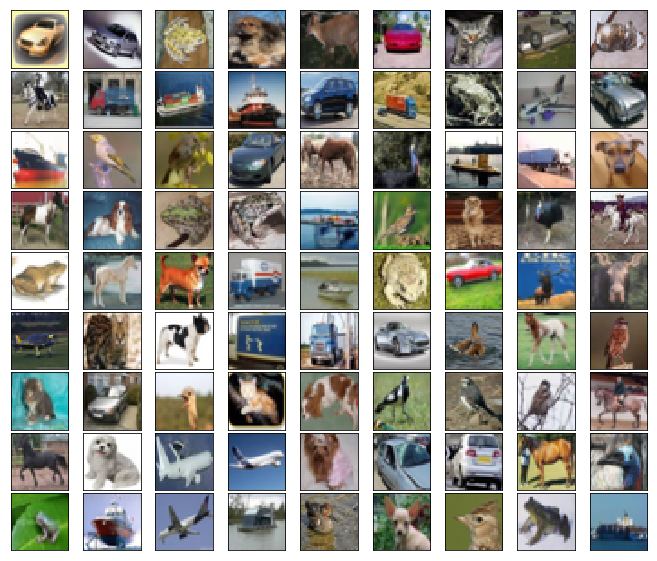

In [3]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(train_X[i])

## 課題2. Data Augmentation

- Flipping (horizontally)
- Random cropping
- ...

### 1. Flipping (horizontally)

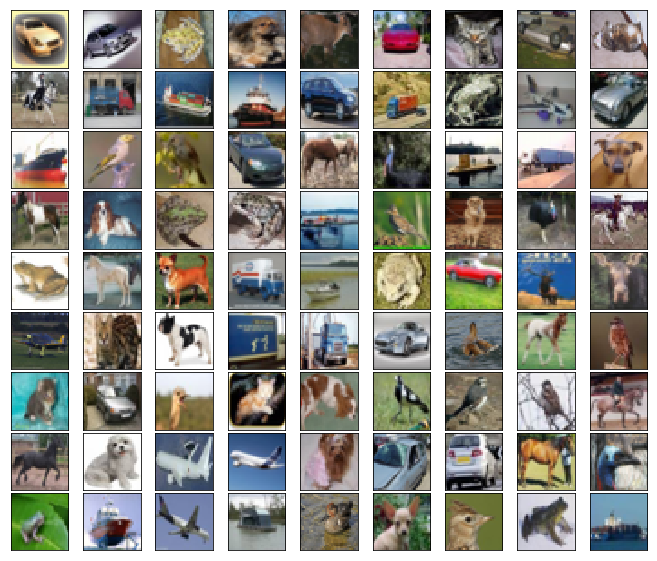

In [4]:
flip_train_X = train_X[:, :, ::-1, :]

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(flip_train_X[i])

### 2. Random cropping

- サイズを同じにするために，拡大したあとcropping，paddingしてからcroppingなどの方法がある．
- cropは学習時に各バッチに対して行うことも多い．
- 今回はDeep Residual Learning for Image Recognitionで使われた手法を実装

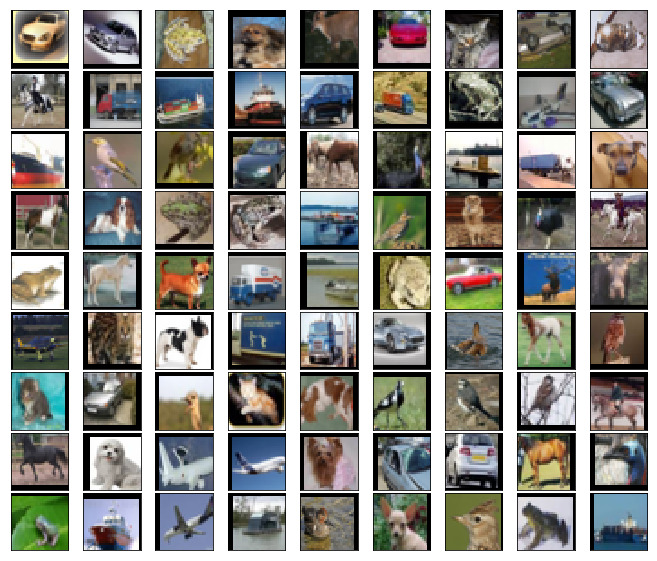

In [5]:
padded = np.pad(train_X, ((0, 0), (4, 4), (4, 4), (0, 0)), mode='constant')
crops = rng.randint(8, size=(len(train_X), 2))
cropped_train_X = [padded[i, c[0]:(c[0]+32), c[1]:(c[1]+32), :] for i, c in enumerate(crops)]
cropped_train_X = np.array(cropped_train_X)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(cropped_train_X[i])

## 課題3. Preprocessing

- Global Contrast Normalization (GCN)
- ZCA Whitening
- ...

### 1. Global Contrast Normalization (GCN)

$$ {\bf x}^{norm} = \frac{{\bf x} - \bar{{\bf x}}}{\sqrt{\sigma_{{\bf x}}}} $$

- 通常の標準化とは違い，画像ごと
- コントラストが低くなる

In [6]:
def gcn(x):
    mean = np.mean(x, axis=(1, 2, 3), keepdims=True)
    std = np.std(x, axis=(1, 2, 3), keepdims=True)
    return (x - mean)/std

In [7]:
normalized_train_X = gcn(train_X)

In [8]:
# 可視化用に画像を[0,1]にする&次元を変更
def deprocess(x):
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    _x = _x
    return _x

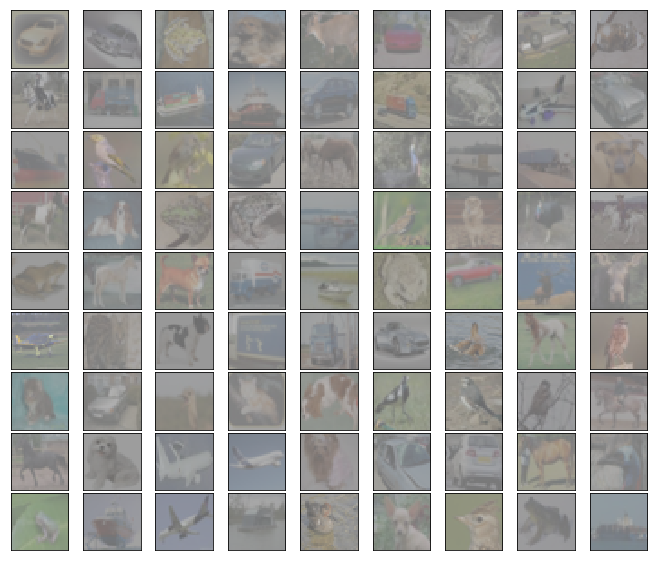

In [9]:
_normalized_train_X = deprocess(normalized_train_X)
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(_normalized_train_X[i])

del _normalized_train_X

### 2. Zero-phase Component Analysis (ZCA) Whitening

$$ {\bf x}^{ZCA} = A(\Lambda + \epsilon I)^{-\frac{1}{2}} A^{\mathrm{T}} ({\bf x} - \bar{\bf x}) $$

- np.linalg.svdを使うと便利（厳密にはnp.linalg.svdは特異値分解）

In [10]:
class ZCAWhitening:
    def __init__(self, epsilon=1e-4):
        self.epsilon = epsilon
        self.mean = None
        self.ZCA_matrix = None

    def fit(self, x):
        x = x.reshape(x.shape[0], -1)
        self.mean = np.mean(x, axis=0)
        x -= self.mean
        cov_matrix = np.dot(x.T, x) / x.shape[0]
        A, d, _ = np.linalg.svd(cov_matrix)
        self.ZCA_matrix = np.dot(np.dot(A, np.diag(1. / np.sqrt(d + self.epsilon))), A.T)

    def transform(self, x):
        shape = x.shape
        x = x.reshape(x.shape[0], -1)
        x -= self.mean
        x = np.dot(x, self.ZCA_matrix.T)
        return x.reshape(shape)

In [11]:
zca = ZCAWhitening()
zca.fit(train_X)
zca_train_X = zca.transform(train_X)

In [12]:
# 可視化用に各画像ごとに[0,1]にする(ZCAの結果を見やすくするため)&次元を変更
def deprocess_each_img(x):
    _min = np.min(x, axis=(1, 2, 3), keepdims=True)
    _max = np.max(x, axis=(1, 2, 3), keepdims=True)
    _x = (x - _min)/(_max - _min)
    _x = _x
    return _x

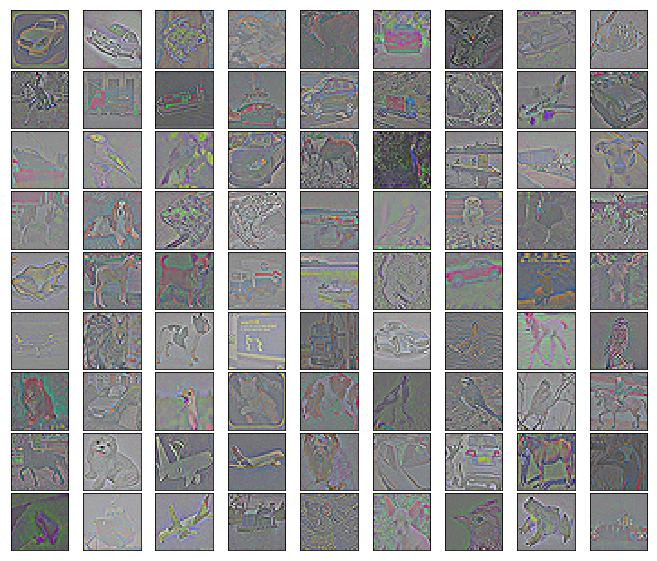

In [13]:
_zca_train_X = deprocess_each_img(zca_train_X)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(_zca_train_X[i])

del _zca_train_X

## 課題4. Batch Normalization

![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png?w=1008)

In [14]:
class BatchNorm:
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        self.gamma = tf.Variable(np.ones(shape, dtype='float32'), name='gamma')
        self.beta  = tf.Variable(np.zeros(shape, dtype='float32'), name='beta')
        self.epsilon = epsilon

    def f_prop(self, x):
        if len(x.get_shape()) == 2:
            mean, var = tf.nn.moments(x, axes=0, keepdims=True)
            std = tf.sqrt(var + self.epsilon)
        elif len(x.get_shape()) == 4:
            mean, var = tf.nn.moments(x, axes=(0,1,2), keep_dims=True)
            std = tf.sqrt(var + self.epsilon)
        normalized_x = (x - mean) / std
        return self.gamma * normalized_x + self.beta

## 課題5. 畳み込みニューラルネットワーク(Convolutional Neural Networks)の実装と学習

### 1. 各層クラスの実装

#### 畳み込み層

In [15]:
class Conv:
    def __init__(self, filter_shape, function=lambda x: x, strides=[1,1,1,1], padding='VALID'):
        # Xavier
        fan_in = np.prod(filter_shape[:3])
        fan_out = np.prod(filter_shape[:2]) * filter_shape[3]
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(fan_in + fan_out)),
                        high=np.sqrt(6/(fan_in + fan_out)),
                        size=filter_shape
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros((filter_shape[3]), dtype='float32'), name='b') # バイアスはフィルタごと
        self.function = function
        self.strides = strides
        self.padding = padding

    def f_prop(self, x):
        u = tf.nn.conv2d(x, self.W, strides=self.strides, padding=self.padding) + self.b
        return self.function(u)

#### プーリング層

In [16]:
class Pooling:
    def __init__(self, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID'):
        self.ksize = ksize
        self.strides = strides
        self.padding = padding
    
    def f_prop(self, x):
        return tf.nn.max_pool(x, ksize=self.ksize, strides=self.strides, padding=self.padding)

#### 平滑化層（4次元->2次元）

In [17]:
class Flatten:
    def f_prop(self, x):
        return tf.reshape(x, (-1, np.prod(x.get_shape().as_list()[1:])))

#### 全結合層

In [18]:
class Dense:
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        # Xavier
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + out_dim)),
                        high=np.sqrt(6/(in_dim + out_dim)),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))
        self.function = function

    def f_prop(self, x):
        return self.function(tf.matmul(x, self.W) + self.b)

#### 活性化層

In [19]:
class Activation:
    def __init__(self, function=lambda x: x):
        self.function = function
    
    def f_prop(self, x):
        return self.function(x)

### 2. 計算グラフ構築 & パラメータの更新設定

In [20]:
layers = [ # (縦の次元数)x(横の次元数)x(チャネル数)
    Conv((3, 3, 3, 32)), # 32x32x3 -> 30x30x32
    BatchNorm((30, 30, 32)),
    Activation(tf.nn.relu),
    Pooling((1, 2, 2, 1)), # 30x30x32 -> 15x15x32
    Conv((3, 3, 32, 64)), # 15x15x32 -> 13x13x64
    BatchNorm((13, 13, 64)),
    Activation(tf.nn.relu),
    Pooling(((1, 2, 2, 1))), # 13x13x64 -> 6x6x64
    Conv((3, 3, 64, 128)), # 6x6x64 -> 4x4x128
    BatchNorm((4, 4, 128)),
    Activation(tf.nn.relu),
    Pooling((1, 2, 2, 1)), # 4x4x128 -> 2x2x128
    Flatten(),
    Dense(2*2*128, 256, tf.nn.relu),
    Dense(256, 10, tf.nn.softmax)
]

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
t = tf.placeholder(tf.float32, [None, 10])

def f_props(layers, x):
    for layer in layers:
        x = layer.f_prop(x)
    return x

y = f_props(layers, x)

cost = -tf.reduce_mean(tf.reduce_sum(t * tf.log(tf.clip_by_value(y, 1e-10, 1.0)), axis=1))
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

valid = tf.argmax(y, 1)

### 3. 学習

#### Preprocessing

In [21]:
zca = ZCAWhitening()
zca.fit(gcn(train_X))
zca_train_X = zca.transform(gcn(train_X))
zca_train_y = train_y[:]
zca_valid_X = zca.transform(gcn(valid_X))
zca_valid_y = valid_y[:]

#### 学習

In [22]:
n_epochs = 10
batch_size = 100
n_batches = train_X.shape[0]//batch_size

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(n_epochs):
    zca_train_X, zca_train_y = shuffle(zca_train_X, zca_train_y, random_state=random_state)
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        sess.run(train, feed_dict={x: zca_train_X[start:end], t: zca_train_y[start:end]})
    pred_y, valid_cost = sess.run([valid, cost], feed_dict={x: zca_valid_X, t: zca_valid_y})
    print('EPOCH:: %i, Validation cost: %.3f, Validation F1: %.3f' % (epoch + 1, valid_cost, f1_score(np.argmax(valid_y, 1).astype('int32'), pred_y, average='macro')))

EPOCH:: 1, Validation cost: 1.528, Validation F1: 0.458
EPOCH:: 2, Validation cost: 1.320, Validation F1: 0.529
EPOCH:: 3, Validation cost: 1.199, Validation F1: 0.574
EPOCH:: 4, Validation cost: 1.142, Validation F1: 0.601
EPOCH:: 5, Validation cost: 1.097, Validation F1: 0.618
EPOCH:: 6, Validation cost: 1.073, Validation F1: 0.621
EPOCH:: 7, Validation cost: 1.046, Validation F1: 0.634
EPOCH:: 8, Validation cost: 1.027, Validation F1: 0.645
EPOCH:: 9, Validation cost: 1.010, Validation F1: 0.647
EPOCH:: 10, Validation cost: 1.032, Validation F1: 0.649


## 課題7. Activationの可視化

In [ ]:
plt.imshow(deprocess(train_X)[0])

### 1. conv1

In [ ]:
x = tf.placeholder(tf.float32)

plot_layer = 0

layer_out = x
for layer in layers[:plot_layer+1]:
    layer_out = layer.f_prop(layer_out)

In [ ]:
output = sess.run(layer_out, feed_dict={x: train_X[0][np.newaxis]})

In [ ]:
_output = deprocess(output)
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    ax.imshow(_output[0, :, :, i], cmap='gray')

### 2. conv2

In [ ]:
x = tf.placeholder(tf.float32)

plot_layer = 4

layer_out = x
for layer in layers[:plot_layer+1]:
    layer_out = layer.f_prop(layer_out)

In [ ]:
output = sess.run(layer_out, feed_dict={x: train_X[0][np.newaxis]})

In [ ]:
_output = deprocess(output)
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    ax.imshow(_output[0, :, :, i], cmap='gray')

### 3. conv3

In [ ]:
x = tf.placeholder(tf.float32)

plot_layer = 7

layer_out = x
for layer in layers[:plot_layer+1]:
    layer_out = layer.f_prop(layer_out)

In [ ]:
output = sess.run(layer_out, feed_dict={x: train_X[0][np.newaxis]})

In [ ]:
_output = deprocess(output)
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    ax.imshow(_output[0, :, :, i], cmap='gray')

In [ ]:
sess.close()